In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_missing_40 = train_missing[train_missing.percent<0.4].index
test_missing_40 =  test_missing[test_missing.percent<0.4].index
train_missing_15 = train_missing[train_missing.percent<0.15].index
test_missing_15 =  test_missing[test_missing.percent<0.15].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features_40 = set(train_missing_40) & set(test_missing_40)
features_15 = set(train_missing_15) & set(test_missing_15)
features = set(features_40) - set(categorical_features)
knn_features = set(features) - set(features_15)  

In [10]:
len(features), len(knn_features)

(2259, 512)

In [11]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]
knn_features = [col for col in knn_features if col not in land_sat_feats]

In [12]:
len(features), len(knn_features)

(309, 62)

In [13]:
"""
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

missing_train = train.fillna(9999)
missing_test = test.fillna(9999)

for mcol in tqdm(knn_features):
    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]
    knn_train = missing_train.loc[missing_train[mcol]!=9999]
    knn_mtest = missing_test.loc[missing_test[mcol]==9999]

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(knn_train[features],knn_train[mcol])
    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])

    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")
    train[mcol] = train[mcol].fillna(0)
    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)
    train[mcol] = train[mcol] + train[f"knn_{mcol}"]

    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")
    test[mcol] = test[mcol].fillna(0)
    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].fillna(0)
    test[mcol] = test[mcol] + test[f"knn_{mcol}"]

display(train[knn_features].head(10))
display(test[knn_features].head(10))
"""

'\nfrom sklearn.neighbors import KNeighborsRegressor\nfrom tqdm import tqdm\n\nmissing_train = train.fillna(9999)\nmissing_test = test.fillna(9999)\n\nfor mcol in tqdm(knn_features):\n    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]\n    knn_train = missing_train.loc[missing_train[mcol]!=9999]\n    knn_mtest = missing_test.loc[missing_test[mcol]==9999]\n\n    knn = KNeighborsRegressor(n_neighbors=3)\n    knn.fit(knn_train[features],knn_train[mcol])\n    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])\n    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])\n\n    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")\n    train[mcol] = train[mcol].fillna(0)\n    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)\n    train[mcol] = train[mcol] + train[f"knn_{mcol}"]\n\n    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")\n    test[mcol] = test[mcol].fillna(0)\n    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].filln

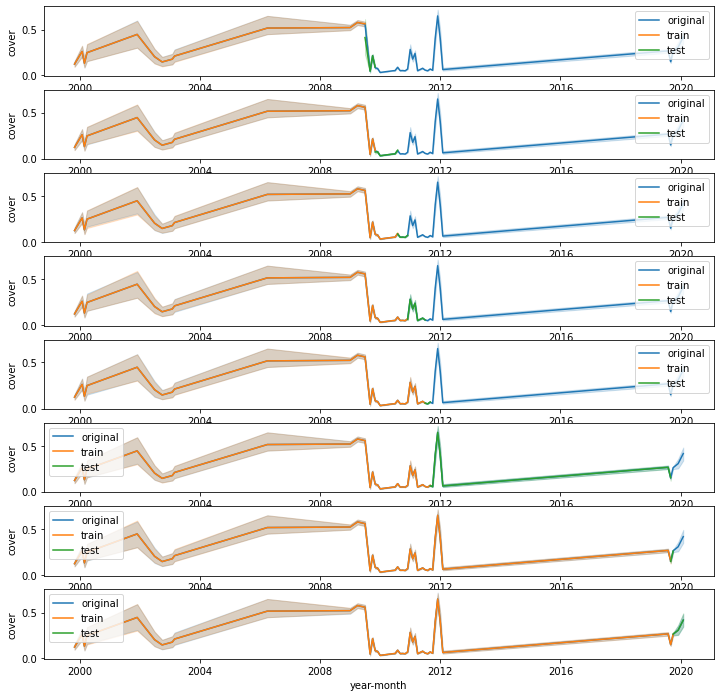

In [14]:
from sklearn.model_selection import TimeSeriesSplit

fig, axes = plt.subplots(8, 1, figsize=(12, 12))

train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train["year-month-mesh20"] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str) + '-' + train.mesh20.astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)

folds = TimeSeriesSplit(n_splits=8)

for i, (train_index, test_index) in enumerate(folds.split(train)):

    sns.lineplot(data=train, x='year-month', y='cover', ax=axes[i], label='original')
    # 学習用データを描く
    sns.lineplot(data=train.iloc[train_index], x='year-month', y='cover', ax=axes[i], label='train')
    # テスト用データを描く
    sns.lineplot(data=train.iloc[test_index], x='year-month', y='cover', ax=axes[i], label='test')

# グラフを表示する
plt.legend()
plt.show()

## Model

In [15]:
#!pip install iterative-stratification

In [16]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [17]:
class CFG:
  ver=63
  model="lightgbm"
  n_folds=8
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover"
  boosting_type="gbdt"
  fold_target1="adv_flag"
  fold_target2="cover"
  fold_target3="cover"

In [18]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df, fold_target, isFlag=False):
  if isFlag:
    Fold = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = GroupKFold(n_splits = CFG.n_folds)
    for num, (train_index, val_index) in enumerate(Fold.split(df, groups=df["year-month-mesh20"])):
      df.loc[val_index, 'fold'] = int(num)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [19]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [20]:
#features = list(features)
features.remove('id')
features.remove('area')
features.remove("year")
#features.remove("month")
features.append("mesh20")

In [21]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [22]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  ctg_list = ["year","month","mesh20"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train['fold'] != fold].reset_index(drop=True)
      valid_folds = train[train['fold'] == fold].reset_index(drop=True)

      print(f"train folds years: {train_folds.year.unique()}")
      print(f"valid folds years: {valid_folds.year.unique()}")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 200,
              early_stopping_rounds=50)
      
      if isFlag:
        pred = model.predict(valid_X)
        predict_proba = model.predict_proba(valid_X)
        valid_folds["Zscore"] = predict_proba[:,1]
        valid_folds[f"{pred_name}_pred"] = pred
      else:
        valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
        test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  if isFlag:
    return oof_df
  else:
    return oof_df,  test_preds

In [23]:
# 傾向スコアマッチング関数
def matching(result1, z_col='Zscore', tr_col="adv_flag", match_id='id'):
    '''
    result1: 介入変数、傾向スコア、共変量のデータフレーム
    '''
    # キャリパー設定
    caliper = result1[z_col].std()*0.2

    # 処置群抽出
    Tr = result1[result1[tr_col]>0][[match_id, z_col]].copy().reset_index(drop=True)
    Tr.index = Tr[match_id]
    # 対照群抽出
    Ctl = result1[result1[tr_col]==0][[match_id, z_col]].copy().reset_index(drop=True)
    Ctl.index = Ctl[match_id]
    
    Ctl_vals = np.copy(Ctl[z_col].to_numpy()) # 配列化
    Ctl_ids = np.copy(Ctl.index.to_numpy()) # 配列化
    Tr_vals_dict = Tr[z_col].sort_values(ascending=False).to_dict() # 処置群の傾向スコアで降順にして辞書化

    # マッチングを実施していく
    match_results = [] # 結果を入れる箱
    for i, (cid, tr_val) in tqdm(enumerate(Tr_vals_dict.items())):
        # cid:user_id, tr_val:傾向スコア
        # argminで処置群と最も傾向スコアの差が小さい対照群のインデックス番号取得
        nearId = np.abs(Ctl_vals - tr_val).argmin()
        # 傾向スコアの差がキャリパーより大きかった場合、マッチングしない
        if np.abs(tr_val-Ctl_vals[nearId])>caliper:
            continue
        # 傾向スコアの差がキャリパーより小さかった場合、マッチングした者同士をリストに格納
        match_results.append([cid, Ctl_ids[nearId], tr_val, Ctl_vals[nearId]])
        # 次のマッチングで重複してマッチングしないように対照群のスコアを-9999に置き換える
        np.put(Ctl_vals, [nearId], -9999)

    # リストをdf化
    match_results_df = pd.DataFrame(match_results, columns=['Tr', 'Ctl', 'Tr_zscore', 'Ctl_zscore'])
    match_results_df['diff'] = np.abs(match_results_df['Tr_zscore']-match_results_df['Ctl_zscore'])
    print(match_results_df['diff'].max())
    return match_results_df

In [24]:
#model1 = lgb.LGBMClassifier(**params1)
#flag_oof = get_pred(df, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)

In [25]:
#match_results_df = matching(flag_oof, z_col='Zscore', tr_col='adv_flag', match_id='id')
#display(match_results_df)

In [26]:
#match_id = match_results_df.Ctl.tolist()
#match_train = train[train["id"].isin(match_id)].reset_index(drop=True)
#display(match_train)

fold
0    1768
1    1768
2    1767
3    1767
4    1767
5    1768
6    1768
7    1767
dtype: int64

===============  FOLD : 0  ===============
train folds years: [1999. 2000. 2001. 2002. 2003. 2006. 2009. 2010. 2011. 2012. 2019. 2020.]
valid folds years: [2000. 2009. 2010. 2011. 2019.]
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	valid_0's rmse: 0.208074
RMSE 0.20807422491153776
===============  FOLD : 1  ===============
train folds years: [1999. 2000. 2001. 2002. 2003. 2006. 2009. 2010. 2011. 2012. 2019. 2020.]
valid folds years: [2003. 2009. 2010. 2011. 2019.]
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.162982
Early stopping, best iteration is:
[154]	valid_0's rmse: 0.161299
RMSE 0.16129889857423343
===============  FOLD : 2  ===============
train folds years: [2000. 2001. 2002. 2003. 2006. 2009. 2010. 2011. 2012. 2019. 2020.]
valid folds years: [1999. 2000. 2002. 2003. 2009. 2010. 2011. 2019.]
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteratio

,feature,importance
169,warm_sst,0.014525
150,fetch,0.013784
264,hist_warm_sst,0.013756
185,MAX_CI,0.012658
132,depth,0.012219
135,lat,0.010653
21,sst_ymd,0.010324
13,MIN_GARI,0.009555
244,river_dist,0.008677
26,Date_Acquired,0.008512


RMSE 0.18341507148537659


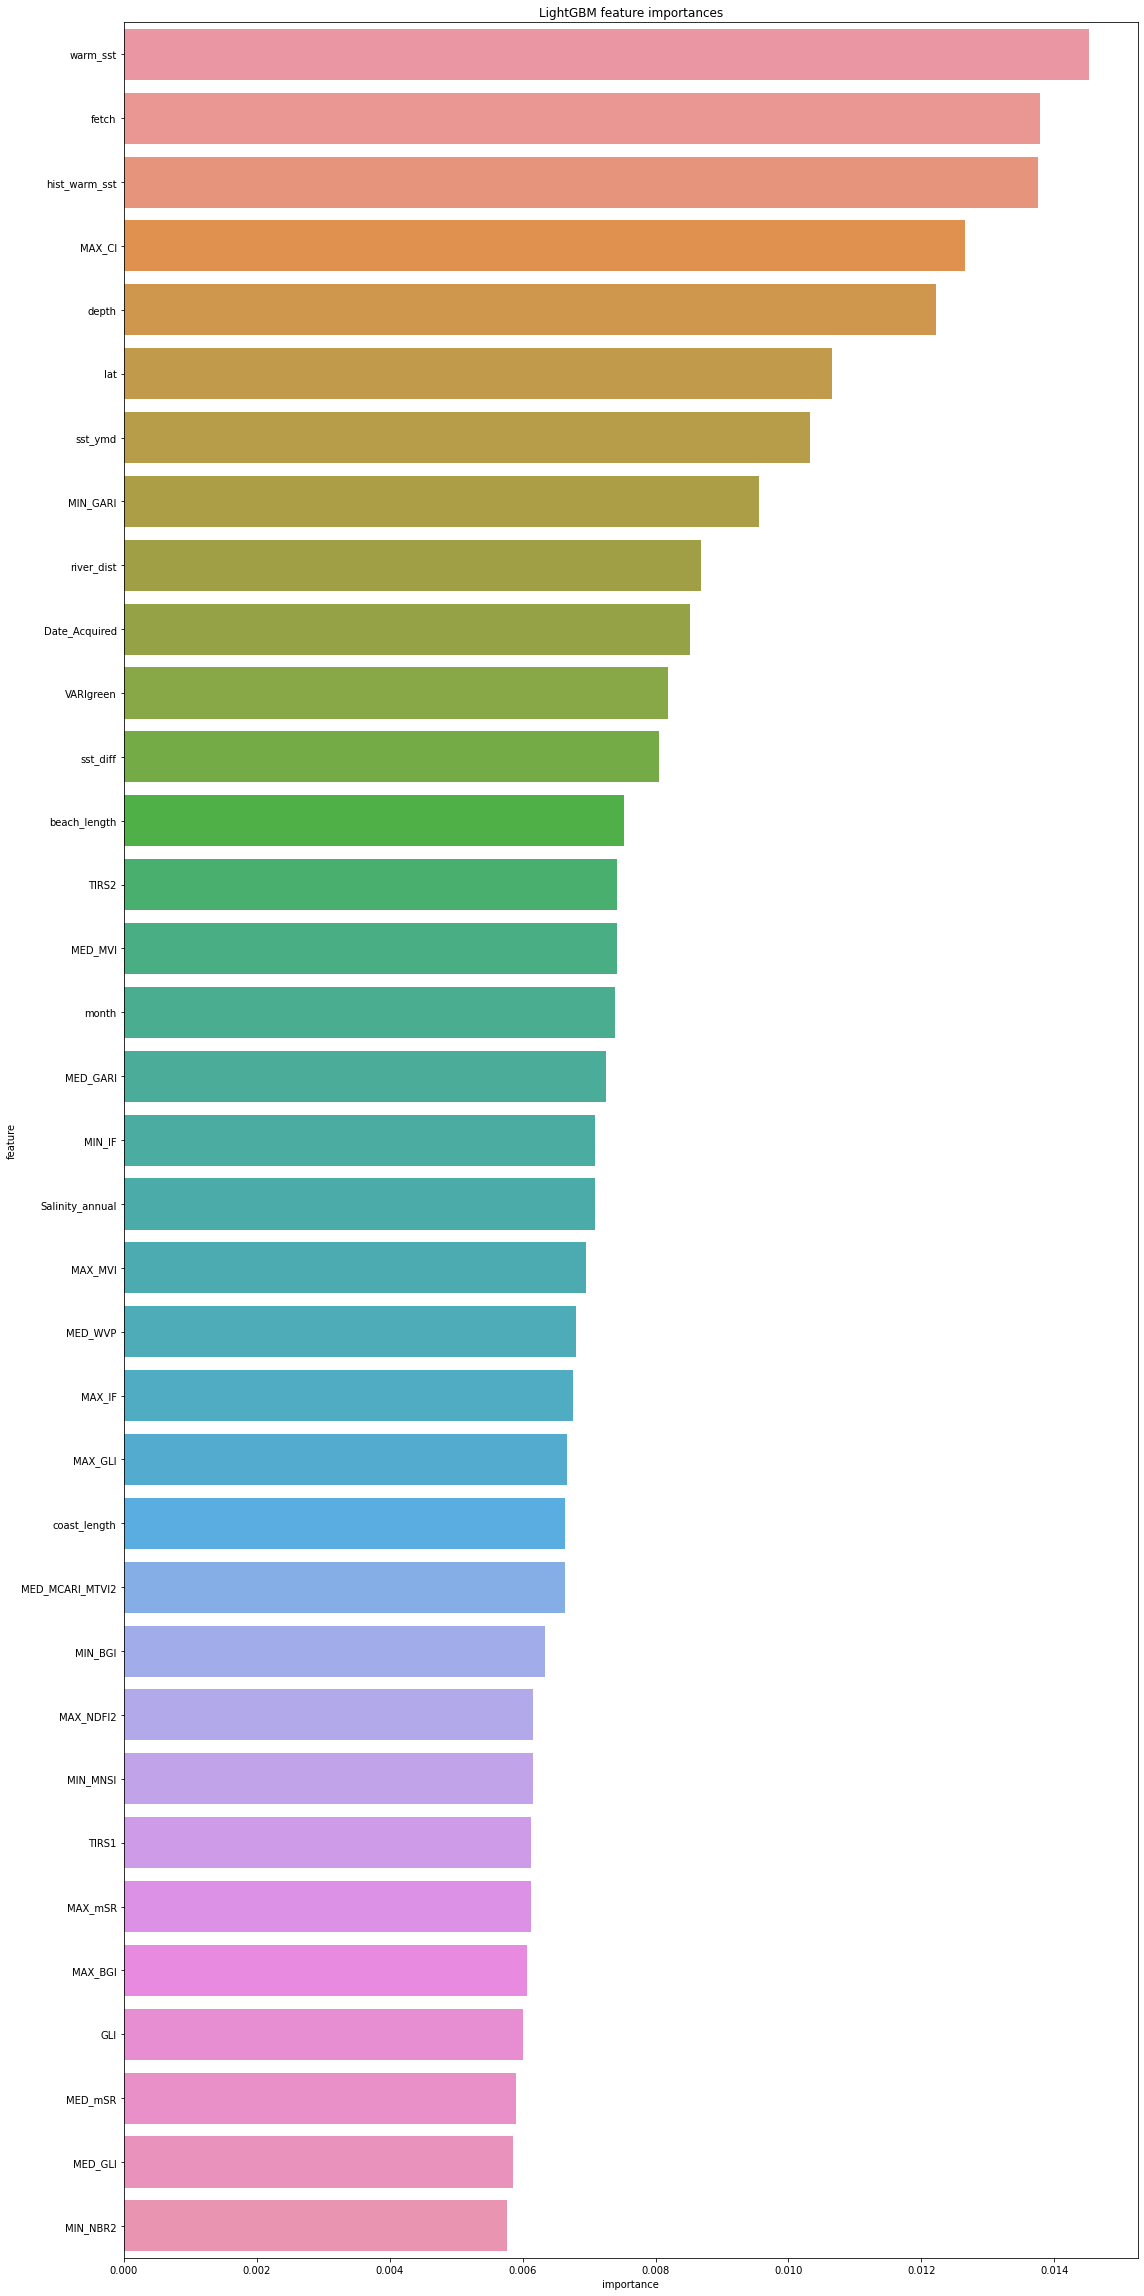

In [27]:
model2 = lgb.LGBMRegressor(**params2)
oof_df, test_pred = get_pred(train, test, CFG.fold_target3, CFG.target_cols2, model2)

In [28]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["_pred"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.18341283934229483


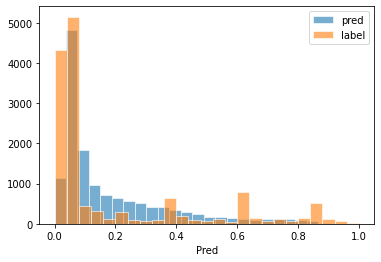

In [29]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [30]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,0.064359
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,0.067780
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,0.065401
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,0.045712
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,0.267525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.260930,-0.187582,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,0.066844
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.286240,-0.264021,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,0.046520
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.316359,-0.123194,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,0.276564
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.302570,-0.276085,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,0.160427


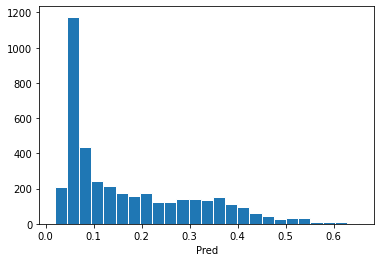

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,0.064359
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,0.067780
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,0.065401
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,0.045712
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,0.267525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.260930,-0.187582,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,0.066844
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.286240,-0.264021,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,0.046520
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.316359,-0.123194,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,0.276564
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.302570,-0.276085,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,0.160427


In [31]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)